# Text classification

In [20]:
%load_ext autoreload
%reload_ext autoreload

### imports and globals

In [13]:
T5_SMALL = "t5-small"
GPT = "gpt2"  # 117M parameters as per https://huggingface.co/transformers/v3.3.1/pretrained_models.html # "openai-gpt"

In [14]:
# opt
from collections import defaultdict

# mandatory imports
from pathlib import Path
from datasets import load_dataset

import torch
from transformers import AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.data import random_split
import collections
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding


In [15]:
import wandb
wandb.login()

True

## Globals

In [16]:
VALID_SIZE = 0.1
BATCH_SIZE = 32
SEED = 42
METRIC_NAME = "f1"
N_EPOCHS = 10

### load dataset

In [17]:
raw_dataset = load_dataset('ag_news', cache_dir="./datasets/.cache/huggingface_datasets")

Found cached dataset ag_news (/home/jovyan/llm_peft_exploration/notebooks/datasets/.cache/huggingface_datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
id2label = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

label2id = {v:k for k,v in id2label.items()}

#### explore shape of dataset

In [19]:
{k: len(raw_dataset[k]) for k in raw_dataset}

{'train': 120000, 'test': 7600}

In [20]:
raw_dataset['test'][0] 

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
 'label': 2}

### Preprocess dataset


#### Set config parameters

In [21]:
# max_length = 384
max_input_length = 364
max_target_length = 32
MAX_PREPROCESSING_LENGTH = 128

#### Define utils

In [22]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]  # this has n_rows which = batch_size
    # encode text
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_PREPROCESSING_LENGTH, return_tensors='pt')
    # add labels
    labels_batch = torch.tensor(examples['label'])
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = torch.nn.functional.one_hot(labels_batch)
    labels_matrix = labels_matrix.float() 
    encoding["label"] = labels_matrix#.tolist()
  
    return encoding


In [23]:
def prepare_dataset(ds, tokenizer, create_validation_split=False, validation_prop=0.1):
    encoded_dataset = ds.map(preprocess_data, batched=True)
    encoded_dataset.set_format("torch")
    
    # create train/valid sets
    print(f"creating validation split: {str(create_validation_split)}")
    if create_validation_split:
        train_dataset, validation_dataset= encoded_dataset['train'].train_test_split(test_size=validation_prop).values()
    return {'train': train_dataset, 'valid': validation_dataset, 'test': encoded_dataset['test']}


In [41]:
def describe_label_distr_from_data_loader(dl):
    label_list = []
    print(f"#samples in split: {len(dl)}")
    for idx, item in enumerate(dl):
        batch_labels_onehot = item['label']#.tolist()
        batch_labels = [torch.argmax(label_onehot).item() for label_onehot in batch_labels_onehot]
        label_list.extend(batch_labels)
    print(f'distribution of labels: {collections.Counter(label_list)}')



#### tokenize, encode dataset

In [25]:
tokenizer = AutoTokenizer.from_pretrained(GPT)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right' 

# more efficient to dynamically pad sentences to max length in a batch during collation than global max length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
encoded_dataset = prepare_dataset(raw_dataset, tokenizer, create_validation_split=True)
valid_loader = DataLoader(encoded_dataset['valid'], batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(encoded_dataset['train'], batch_size=BATCH_SIZE, shuffle=True)

describe_label_distr_from_data_loader(valid_loader)
describe_label_distr_from_data_loader(train_loader)

Loading cached processed dataset at /home/jovyan/llm_peft_exploration/notebooks/datasets/.cache/huggingface_datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-013e24b39d800e64.arrow
Loading cached processed dataset at /home/jovyan/llm_peft_exploration/notebooks/datasets/.cache/huggingface_datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dea2583dcfbada18.arrow


creating validation split: True
distribution of labels: Counter({2: 3036, 0: 3019, 3: 3014, 1: 2931})
distribution of labels: Counter({1: 27069, 3: 26986, 0: 26981, 2: 26964})


In [ ]:
notebooks/openprompt_ag_news.ipynb
notebooks/openprompt_glue_clf.ipynb
notebooks/question_answering-generative.ipynb
notebooks/question_answering.ipynb
notebooks/sequential_training_clf_ag_news-Copy1.ipynb
notebooks/vanilla_clf_ag_news-archive.ipynb
notebooks/vanilla_clf_ag_news.ipynb

### training loop

In [27]:
VALID_SIZE = 0.1
BATCH_SIZE = 32
SEED = 42
METRIC_NAME = "f1"
N_EPOCHS = 50

In [28]:
MODEL_DIR = Path(f"data/models_20230606")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(GPT, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(label2id),
                                                           id2label=id2label,
                                                           label2id=label2id)

model.config.pad_token_id = model.config.eos_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


evals

In [30]:
from transformers import EvalPrediction

def multi_label_metrics(predictions, labels, threshold=0.5):
    # source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

import numpy as np

# consider std text clf that assumes more of a softmax process
def compute_metrics_multiclass_singlelabel(p: EvalPrediction):
    predictions = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    labels = p.label_ids
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
vars(train_loader)

### Custom batch sampling

In [35]:
BASE = 10

VALID_SIZE = 0.1
BATCH_SIZE = 32
SEED = 42
METRIC_NAME = "f1"
N_EPOCHS = 50
LEARNING_RATE = 2e-5

### experiment - sequential supervision

In [36]:
from training_utils import SequentialTrainingBatchSampler
custom_sequential_sampler = SequentialTrainingBatchSampler(encoded_dataset['train'], batch_size=-1, base=BASE)
for i, batch in enumerate(custom_sequential_sampler):
    print(f"Batch number #{i}:  {batch}")
    if i>=1:
        break

Batch number #0:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Batch number #1:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [37]:
model.device, len(custom_sequential_sampler), MODEL_DIR

(device(type='cpu'), 6, PosixPath('data/models_20230606'))

In [45]:
from torch.utils.data import Subset
from typing import Callable
from transformers import EarlyStoppingCallback
MODEL_DIR_NEW = Path(f"data/models_20230606_new")

def train_model_series_with_sequential_sampler(batch_size=BATCH_SIZE, n_epochs=5,
                                              compute_metrics: Callable = None, output_model_dir=MODEL_DIR_NEW, 
                                               learning_rate=LEARNING_RATE, metric_name=METRIC_NAME):
    total_subset_idx = []
    sequential_supervision_val_scores = []
    sequential_supervision_test_scores = []
    for idx, idx_batch in enumerate(custom_sequential_sampler):
        print(idx)
        if idx>4:
            break
        sequence_n_output_dir = output_model_dir.joinpath(f"_{idx}")
        batch_dataset = Subset(encoded_dataset['train'], idx_batch)
        print(f"Number of training data points: {len(idx_batch)}")
        args = TrainingArguments(
            output_dir=sequence_n_output_dir,
            evaluation_strategy="steps", #epoch",
            eval_steps = 500,
            save_strategy="steps", #epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=n_epochs,
            weight_decay=0.01,
            metric_for_best_model=metric_name,
            logging_dir='./logs',            # directory for storing logs*
            logging_steps=2000,
            # report_to='wandb',
            load_best_model_at_end = True,
            save_total_limit = 2,
        )

        trainer = Trainer(
                    model,
                    args,
                    train_dataset=batch_dataset,
                    eval_dataset=encoded_dataset['valid'],
                    tokenizer=tokenizer,
                    compute_metrics=compute_metrics,
            #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
                    #data_collator=data_collator
                )
        trainer.train()


        print(f"evaluating on test set")
        trainer.eval_dataset=encoded_dataset['test']
        test_scores = trainer.evaluate()
        sequential_supervision_test_scores.append(test_scores)
        #trainer.save()


        print(f"evaluating on validation set")
        trainer.eval_dataset=encoded_dataset['valid']
        val_scores = trainer.evaluate()        
        sequential_supervision_val_scores.append(val_scores)
    
    return sequential_supervision_val_scores, sequential_supervision_test_scores



In [46]:
sequential_supervision_val_scores, sequential_supervision_test_scores = train_model_series_with_sequential_sampler(compute_metrics=compute_metrics)
print([score['eval_accuracy'] for score in sequential_supervision_val_scores])
print([score['eval_accuracy'] for score in sequential_supervision_test_scores])

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
The following columns in the

0
Number of training data points: 10


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 32


evaluating on test set


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32


evaluating on validation set


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 100
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 20
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
The following columns in t

1
Number of training data points: 100


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 32


evaluating on test set


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32


evaluating on validation set


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


2
Number of training data points: 1000


The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 32


evaluating on test set


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32


evaluating on validation set


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1565


3
Number of training data points: 10000


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
500,No log,0.118460,0.912121,0.938667,0.893500
1000,No log,0.119375,0.918987,0.945083,0.904500
1500,No log,0.121148,0.920249,0.946097,0.906750


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32
Saving model checkpoint to data/models_20230606_new/_3/checkpoint-500
Configuration saved in data/models_20230606_new/_3/checkpoint-500/config.json
Model weights saved in data/models_20230606_new/_3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in data/models_20230606_new/_3/checkpoint-500/tokenizer_config.json
Special tokens file saved in data/models_20230606_new/_3/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore th

evaluating on test set


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32


evaluating on validation set


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 100000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 15625
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
The following column

4
Number of training data points: 100000


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
500,No log,0.101411,0.925276,0.949333,0.913167
1000,No log,0.095647,0.929044,0.951528,0.917917
1500,No log,0.093947,0.931352,0.952917,0.921083
2000,0.101300,0.088588,0.934282,0.954861,0.925083
2500,0.101300,0.090575,0.933149,0.954639,0.924083
3000,0.101300,0.083051,0.938470,0.957847,0.930500
3500,0.101300,0.087891,0.938542,0.958236,0.931500
4000,0.082200,0.093764,0.937957,0.957847,0.931917
4500,0.082200,0.085054,0.936865,0.956708,0.929417
5000,0.082200,0.082930,0.940764,0.959750,0.932667


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32
Saving model checkpoint to data/models_20230606_new/_4/checkpoint-500
Configuration saved in data/models_20230606_new/_4/checkpoint-500/config.json
Model weights saved in data/models_20230606_new/_4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in data/models_20230606_new/_4/checkpoint-500/tokenizer_config.json
Special tokens file saved in data/models_20230606_new/_4/checkpoint-500/special_tokens_map.json
Saving model checkpoint to data/models_20230606_new/_4/checkpoint-1000
Configuration saved in data/models_20230606_new/_4/checkpoint-1000/config.json
Model weights saved in data/models_20230606_new/_4/checkpoint-1000/pytorch_model.bin
tokenizer c

evaluating on test set


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12000
  Batch size = 32


evaluating on validation set
5
[0.10525, 0.171, 0.8311666666666667, 0.90675, 0.9388333333333333]
[0.0968421052631579, 0.16486842105263158, 0.8302631578947368, 0.910921052631579, 0.9415789473684211]


#### writing to file

In [ ]:
import json
with open(MODEL_DIR_NEW.joinpath("val_scores_sequential_vanilla_clf.json"), "w+") as f:
    json.dump(sequential_supervision_val_scores, f)
with open(MODEL_DIR_NEW.joinpath("test_scores_sequential_vanilla_clf.json"), "w+") as f:
    json.dump(sequential_supervision_test_scores, f)

In [ ]:
#[0.0968421052631579, 0.16486842105263158, 0.8302631578947368, 0.910921052631579, 0.9415789473684211]

In [ ]:
0,00	0.0006
0.3325	0.0011
0.4955	0.0166
0.6229	0.2606
0.7095	0.8776

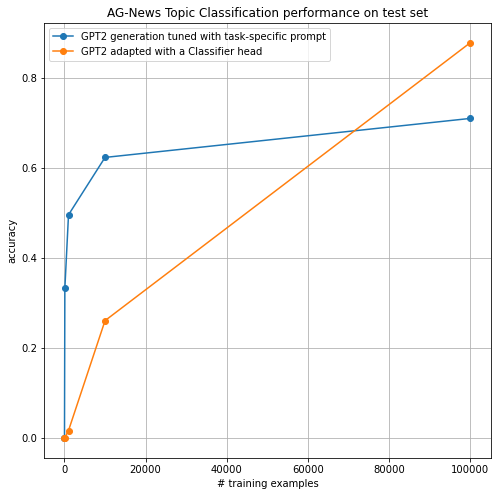

In [6]:
import pandas as pd
df = pd.DataFrame({
   'GPT2 generation tuned with task-specific prompt': [0.0000, 0.3325, 0.4955, 0.6229, 0.7095],
   'GPT2 adapted with a Classifier head': [0.0006, 0.0011, 0.0166, 0.2606, 0.8776],
}, index=[10, 100, 1000, 10000, 100000])
lines = df.plot.line(style="o-", figsize=(8,8), grid=True)
lines.set_ylabel("accuracy")
lines.set_xlabel("# training examples")
lines.set_title("AG-News Topic Classification performance on test set")
fig = lines.get_figure()
fig.savefig("data_points_vs_prompts_ag_news.png")